In [14]:
import numpy as np
import matplotlib.pyplot as plt
from environment_final import PortfolioEnv
from agent_final import DQNAgent
import yfinance as yf
import pandas as pd

In [15]:
tickers = [
    "AAPL", "MSFT", "AMZN", "GOOGL", "NVDA",  # Tech
    "META", "TSLA", "CRM",                   # More tech/growth
    "JPM", "BAC", "GS",                      # Finance
    "JNJ", "PFE", "UNH",                     # Healthcare
    "WMT", "COST", "MCD",                    # Consumer
    "XOM", "CVX"                             # Energy
]

In [16]:
end = pd.Timestamp.today().normalize()

train_start = end - pd.DateOffset(months=150)
train_end   = end - pd.DateOffset(months=12)

test_start  = train_end
test_end    = end

print("Train:", train_start.date(), "->", train_end.date())
print("Test :", test_start.date(), "->", test_end.date())

buy_sell_percentages = [0.05, 0.1, 0.2, 1.0]

train_env = PortfolioEnv(
    tickers=tickers,
    start_date=train_start,
    end_date=train_end,
    break_by_month=True,
    initial_cash=100000,
    buy_sell_percentages=buy_sell_percentages,
    episode_period="month",   # change to year if you want yearly episodes
)

env = train_env

state_dim = train_env.observation_space.shape[0]
actions_per_stock = train_env.action_space.nvec[0]
n_stocks = len(tickers)

print(f"Train episodes (periods found): {train_env.total_episodes}")
print(f"State dim: {state_dim}, Actions/stock: {actions_per_stock}, Stocks: {n_stocks}")

Train: 2013-06-14 -> 2024-12-14
Test : 2024-12-14 -> 2025-12-14


c:\Users\bassoc\OneDrive - Milwaukee School of Engineering\Desktop\Reinforcement Learning\final\environment_final.py:55: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.tickers, start=start_date, end=end_date, interval="1d", progress=False)


Train episodes (periods found): 139
State dim: 78, Actions/stock: 9, Stocks: 19


c:\Users\bassoc\OneDrive - Milwaukee School of Engineering\Desktop\Reinforcement Learning\final\environment_final.py:80: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download("SPY", start=start_date, end=end_date, interval="1d", progress=False)


In [17]:
state_dim = env.observation_space.shape[0]
actions_per_stock = env.action_space.nvec[0]
n_stocks = len(tickers)
print(f"State dimension: {state_dim}, Actions per stock: {actions_per_stock}, Number of stocks: {n_stocks}")


State dimension: 78, Actions per stock: 9, Number of stocks: 19


In [18]:
agent = DQNAgent(
    state_dim=state_dim,
    n_stocks=n_stocks,
    actions_per_stock=actions_per_stock,
    lr=0.001,
    gamma=0.99,
    batch_size=64,
    buffer_capacity=100000,
    epsilon_start=1.0,
    epsilon_min=0.1,
    epsilon_decay=0.9995,
    target_update_freq=100
)

In [19]:

epochs = 5
episode_count = train_env.total_episodes * epochs
rewards_history = []

for ep in range(episode_count):
    state = env.reset()
    done = False
    total_reward = 0.0
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, info = env.step(action)
        agent.store_transition(state, action, reward, next_state if next_state is not None else np.zeros_like(state), done)
        agent.train_step()
        state = next_state
        total_reward += reward
    rewards_history.append(total_reward)

    if (ep+1) % 5 == 0:
        print(f"Episode {ep+1}/{episode_count}, Total Reward: {total_reward:.4f}, Epsilon: {agent.epsilon:.2f}")

Episode 5/695, Total Reward: 0.0068, Epsilon: 0.98
Episode 10/695, Total Reward: -0.0605, Epsilon: 0.93
Episode 15/695, Total Reward: 0.0292, Epsilon: 0.89
Episode 20/695, Total Reward: -0.0157, Epsilon: 0.84
Episode 25/695, Total Reward: 0.0002, Epsilon: 0.80
Episode 30/695, Total Reward: 0.0090, Epsilon: 0.76
Episode 35/695, Total Reward: 0.0205, Epsilon: 0.72
Episode 40/695, Total Reward: 0.0203, Epsilon: 0.68
Episode 45/695, Total Reward: 0.0160, Epsilon: 0.65
Episode 50/695, Total Reward: 0.0123, Epsilon: 0.61
Episode 55/695, Total Reward: -0.0268, Epsilon: 0.58
Episode 60/695, Total Reward: 0.0307, Epsilon: 0.55
Episode 65/695, Total Reward: -0.0410, Epsilon: 0.52
Episode 70/695, Total Reward: 0.0077, Epsilon: 0.50
Episode 75/695, Total Reward: 0.0027, Epsilon: 0.47
Episode 80/695, Total Reward: 0.0182, Epsilon: 0.45
Episode 85/695, Total Reward: -0.0072, Epsilon: 0.42
Episode 90/695, Total Reward: -0.0183, Epsilon: 0.40
Episode 95/695, Total Reward: 0.0339, Epsilon: 0.38
Episode

Loves to buy at first lol

In [20]:
# After training
agent.epsilon = 0.0

In [21]:
eval_env = PortfolioEnv(
    tickers=tickers,
    start_date=test_start,
    end_date=test_end,
    break_by_month=False,
    initial_cash=100000,
    buy_sell_percentages=train_env.buy_sell_percentages
)

state = eval_env.reset()
done = False


c:\Users\bassoc\OneDrive - Milwaukee School of Engineering\Desktop\Reinforcement Learning\final\environment_final.py:55: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.tickers, start=start_date, end=end_date, interval="1d", progress=False)
c:\Users\bassoc\OneDrive - Milwaukee School of Engineering\Desktop\Reinforcement Learning\final\environment_final.py:80: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download("SPY", start=start_date, end=end_date, interval="1d", progress=False)


In [22]:
spy_prices = eval_env.spy_close.copy()

min_len = min(len(spy_prices), eval_env.data_len)
spy_prices = spy_prices[:min_len]

print(f"SPY prices length: {len(spy_prices)}, env length: {eval_env.data_len}, min_len: {min_len}")

SPY prices length: 249, env length: 249, min_len: 249


In [23]:
portfolio_values = []
indi_position_values = {tic: [] for tic in tickers}
shares_history = {tic: [] for tic in tickers}
dates_history = []
spy_values = []

day_counter = 0
initial_portfolio_val = eval_env.initial_cash
initial_spy_holdings = initial_portfolio_val / spy_prices[0]

state = eval_env.reset()
done = False

while not done and day_counter < min_len:
    # log date
    if getattr(eval_env, "dates", None) is not None:
        # dates is now a numpy
        dates_history.append(eval_env.dates[eval_env.current_idx])
    else:
        dates_history.append(day_counter)

    equity = 0.0

    # log per-stock equity
    for i, tic in enumerate(tickers):
        price = eval_env.open_prices[tic][eval_env.current_idx]
        pos_val = eval_env.positions[i] * price

        indi_position_values[tic].append(pos_val)
        equity += pos_val

    # total portfolio value
    curr_val = equity + eval_env.cash
    portfolio_values.append(curr_val)

    # benchmark
    spy_values.append(initial_spy_holdings * spy_prices[day_counter])

    # agent step
    action = agent.select_action(state)
    next_state, reward, done, info = eval_env.step(action)

    # log shares after action
    for i, tic in enumerate(tickers):
        shares_history[tic].append(eval_env.positions[i])

    state = next_state
    day_counter += 1


In [24]:
hhi, div = env.get_hhi()
print("HHI:", hhi, "Diversity:", div)

HHI: 0.2616719429368813 Diversity: 0.7793462824555142


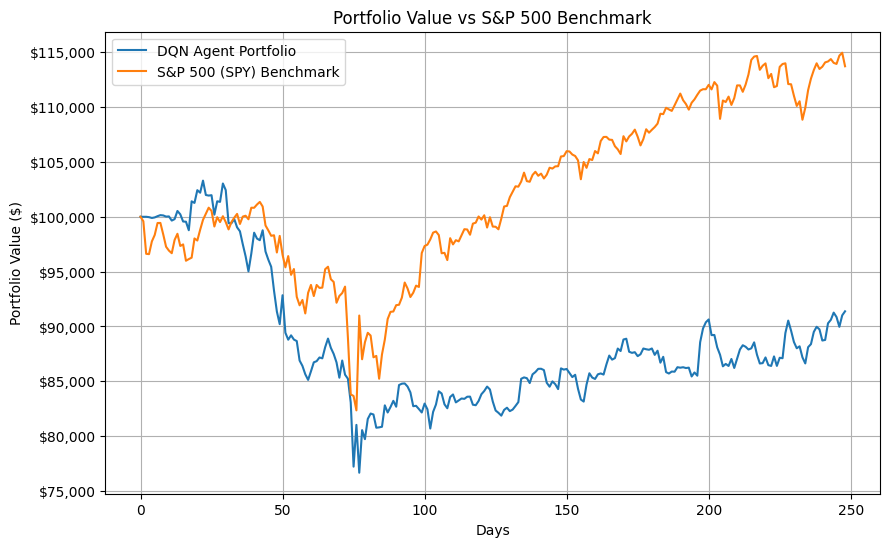

In [25]:
import matplotlib.ticker as mticker

plt.figure(figsize=(10,6))
plt.plot(portfolio_values, label="DQN Agent Portfolio")
plt.plot(spy_values, label="S&P 500 (SPY) Benchmark")
plt.title("Portfolio Value vs S&P 500 Benchmark")
plt.xlabel("Days")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)

ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'${x:,.0f}'))

plt.show()

In [26]:
final_value = portfolio_values[-1]
initial_value = portfolio_values[0]
profit = final_value - initial_value
pct_return = (profit / initial_value) * 100

print(f"\nFinal Portfolio Value: ${final_value:,.2f}")
print(f"Total Profit: ${profit:,.2f} ({pct_return:.2f}%)")


Final Portfolio Value: $91,376.61
Total Profit: $-8,623.39 (-8.62%)


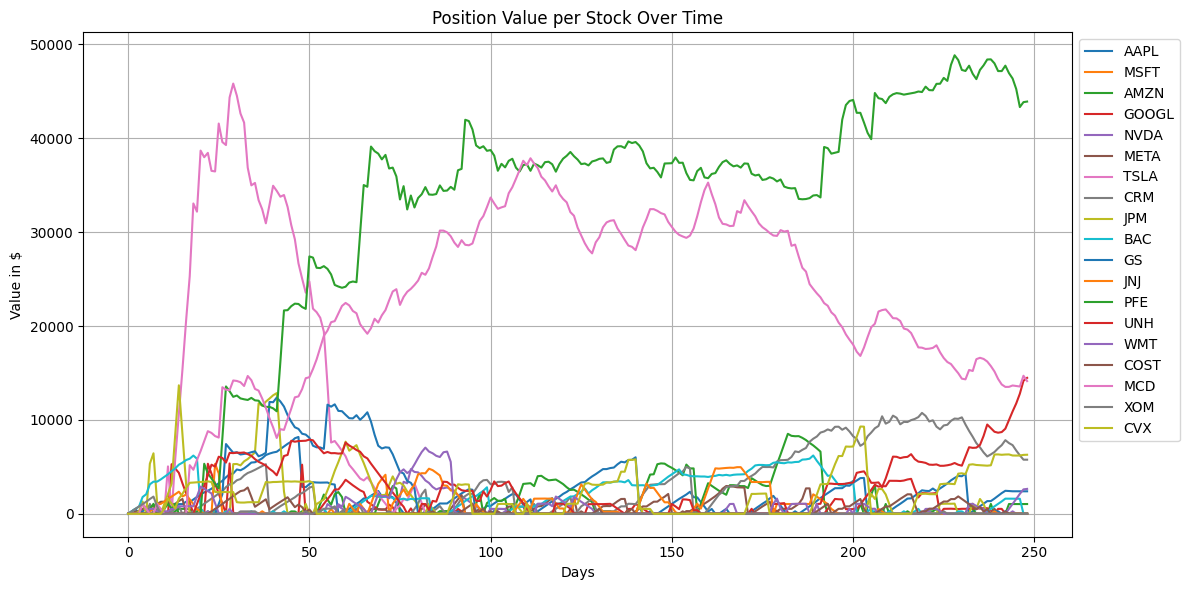

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for tic in tickers:
    plt.plot(indi_position_values[tic], label=tic)

plt.title("Position Value per Stock Over Time")
plt.xlabel("Days")
plt.ylabel("Value in $")
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
import pandas as pd

shares_df = pd.DataFrame(shares_history)
shares_df["date"] = dates_history
shares_df = shares_df.set_index("date")
shares_df.head()

,AAPL,MSFT,AMZN,GOOGL,NVDA,META,TSLA,CRM,JPM,BAC,GS,JNJ,PFE,UNH,WMT,COST,MCD,XOM,CVX
date,,,,,,,,,,,,,,,,,,,
2024-12-16,1.065963,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,5.905963,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2.475645,0.0
2024-12-17,2.123017,0.0,0.0,0.0,0.0,0.421248,0.0,0.0,0.000000,11.864202,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,5.019623,0.0
2024-12-18,0.000000,0.0,0.0,0.0,0.0,0.421248,0.0,0.0,1.124388,17.829041,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,7.555796,0.0
2024-12-19,1.068073,0.0,0.0,0.0,0.0,0.853385,0.0,0.0,5.752255,42.323274,0.0,0.0,0.0,0.0,0.0,0.0,3.703190,10.096220,0.0
2024-12-20,2.133821,0.0,0.0,0.0,0.0,1.300018,0.0,0.0,0.000000,48.555978,0.0,0.0,0.0,0.0,0.0,0.0,1.842897,12.683381,0.0


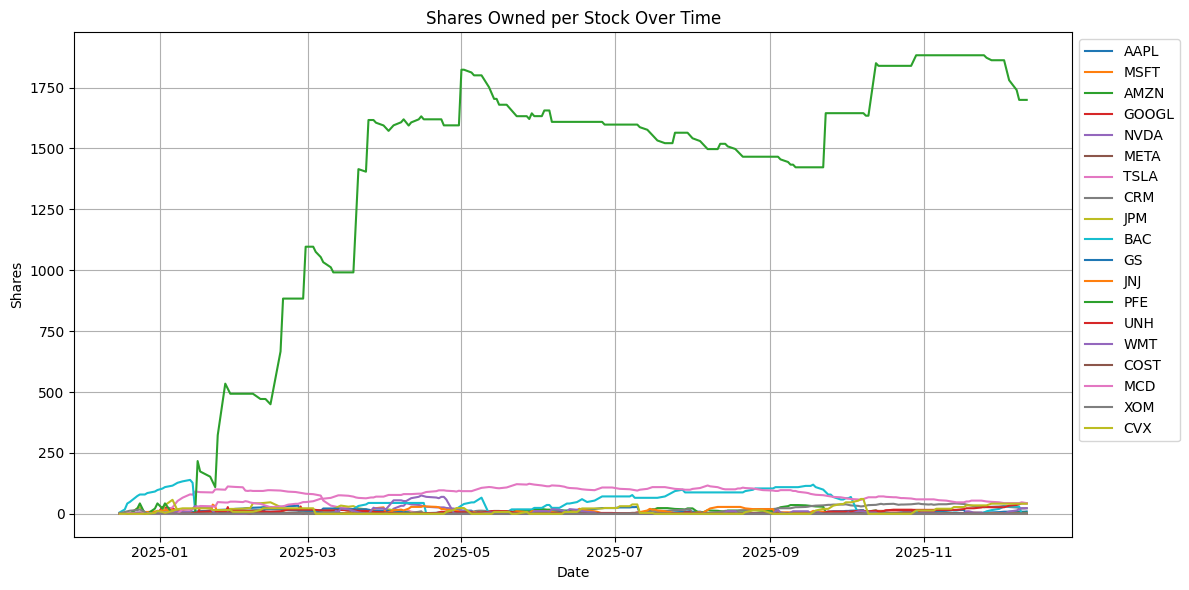

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for tic in tickers:
    plt.plot(shares_df.index, shares_df[tic], label=tic)

plt.title("Shares Owned per Stock Over Time")
plt.xlabel("Date")
plt.ylabel("Shares")
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
plt.grid(True)
plt.tight_layout()
plt.show()
